In [1]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [4]:
df = pd.read_csv('Daily_electricity_consumption.csv')
df.head()

,date_time,active_power_consumed,meter_reading
0,01-01-2009,0.976869,1.946528
1,02-01-2009,1.616326,8.222917
2,03-01-2009,1.328817,7.249306
3,04-01-2009,1.347218,2.253472
4,05-01-2009,1.113889,6.006944


In [5]:
df.tail()

,date_time,active_power_consumed,meter_reading
690,22-11-2010,1.417733,7.038889
691,23-11-2010,1.095511,5.285417
692,24-11-2010,1.247394,8.488889
693,25-11-2010,0.993864,3.522222
694,26-11-2010,1.178230,7.908947


In [6]:
df.shape

(695, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_time              695 non-null    object 
 1   active_power_consumed  695 non-null    float64
 2   meter_reading          695 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.4+ KB


In [9]:
df.isnull().sum()

date_time                0
active_power_consumed    0
meter_reading            0
dtype: int64

In [10]:
time = pd.date_range(start='1/1/2009',end='11/26/2010',freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop('date_time',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [11]:
len(time)

695

In [12]:
df.head()

,active_power_consumed,meter_reading
time_stamp,,
2009-01-01,0.976869,1.946528
2009-01-02,1.616326,8.222917
2009-01-03,1.328817,7.249306
2009-01-04,1.347218,2.253472
2009-01-05,1.113889,6.006944


In [13]:
df.tail()

,active_power_consumed,meter_reading
time_stamp,,
2010-11-22,1.417733,7.038889
2010-11-23,1.095511,5.285417
2010-11-24,1.247394,8.488889
2010-11-25,0.993864,3.522222
2010-11-26,1.178230,7.908947


In [14]:
df = df[['active_power_consumed']]

In [15]:
df

,active_power_consumed
time_stamp,
2009-01-01,0.976869
2009-01-02,1.616326
2009-01-03,1.328817
2009-01-04,1.347218
2009-01-05,1.113889
...,...
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394


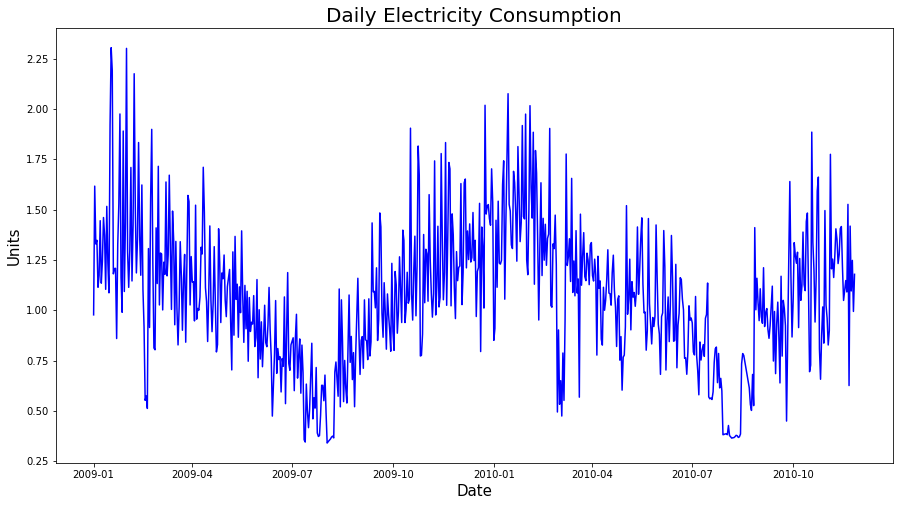

In [16]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [17]:
plt.rcParams['figure.figsize'] = [15,8]

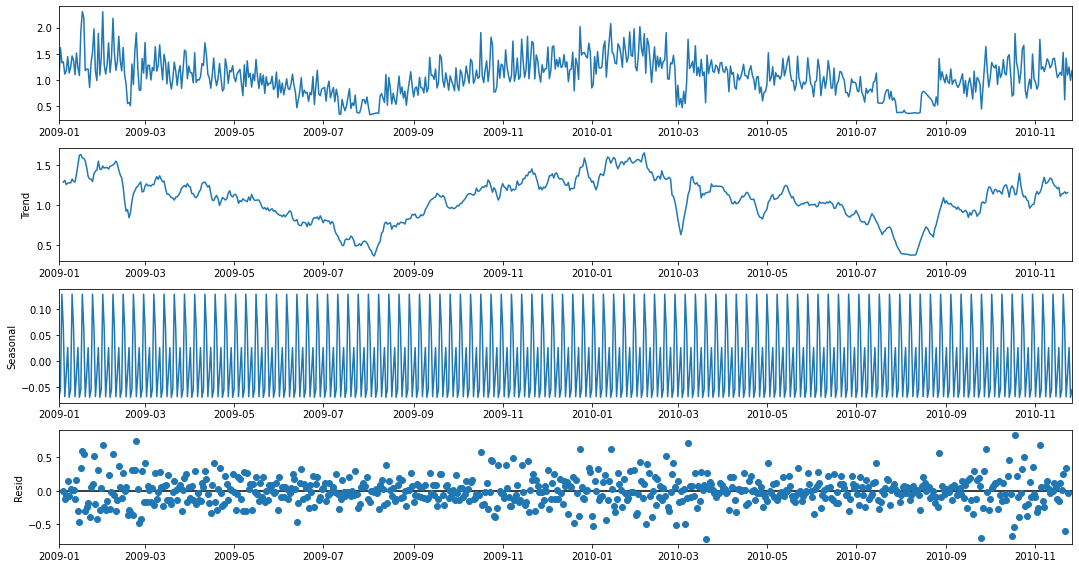

In [18]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

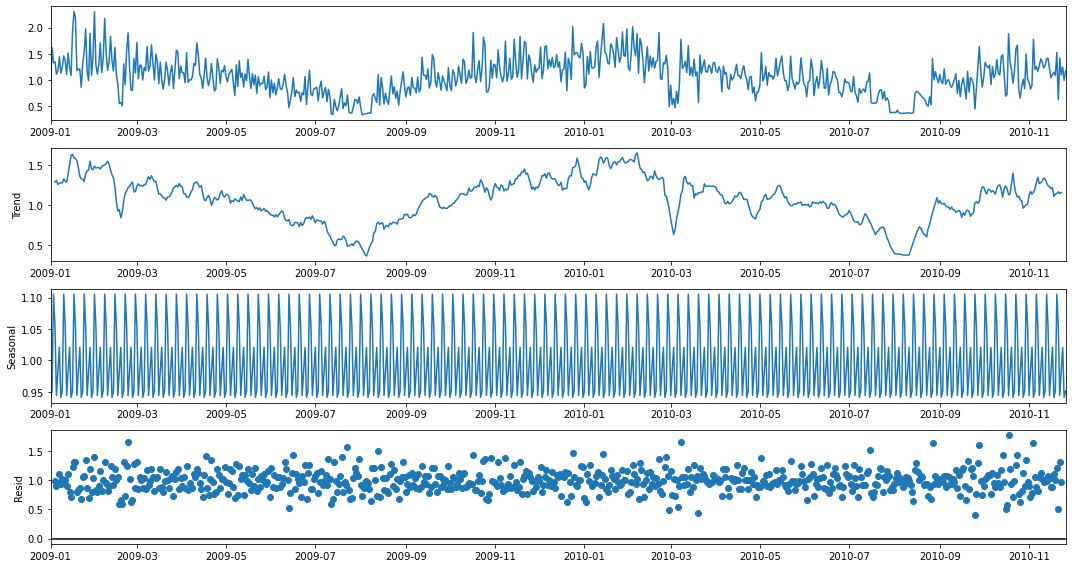

In [19]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

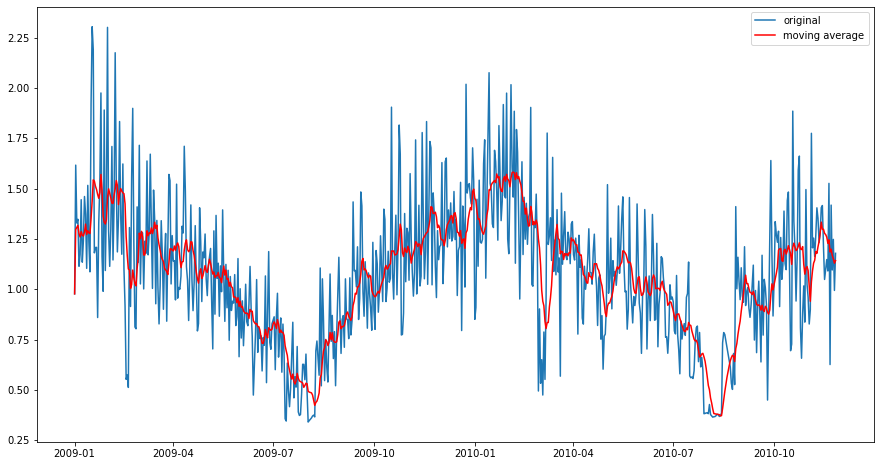

In [20]:
plt.plot(df,label='original')
plt.plot(df.rolling(10,min_periods=0).mean(),label='moving average',color='r')
plt.legend(loc='best')
plt.show()

In [21]:
diff = df.diff(periods=1).dropna()
val = diff.values
res = adfuller(val)
res

(-8.686838241258606,
 4.14138041988578e-14,
 19,
 674,
 {'1%': -3.4400894360545475,
  '5%': -2.865837730028723,
  '10%': -2.5690586760471605},
 26.532914102162295)

In [23]:
# Model building - Exponential Smoothing Techniques

In [24]:
train_end = datetime(2010,9,17)
test_end = datetime(2010,11,27)

In [25]:
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [26]:
train.tail()

,active_power_consumed
time_stamp,
2010-09-13,0.747444
2010-09-14,0.993526
2010-09-15,0.684787
2010-09-16,0.930374
2010-09-17,1.040006


In [27]:
test.tail()

,active_power_consumed
time_stamp,
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394
2010-11-25,0.993864
2010-11-26,1.178230


In [28]:
len(train)

625

In [29]:
len(test)

70

##### Simple Exponential Smoothing

In [30]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,active_power_consumed,No. Observations:,625
Model:,SimpleExpSmoothing,SSE,40.448
Optimized:,True,AIC,-1707.084
Trend:,None,BIC,-1698.209
Seasonal:,None,AICC,-1707.020
Seasonal Periods:,None,Date:,"Thu, 07 Apr 2022"
Box-Cox:,False,Time:,23:50:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1710225,alpha,True
initial_level,1.2960154,l.0,True


In [31]:
SES_predict = SES_model.forecast(len(test))

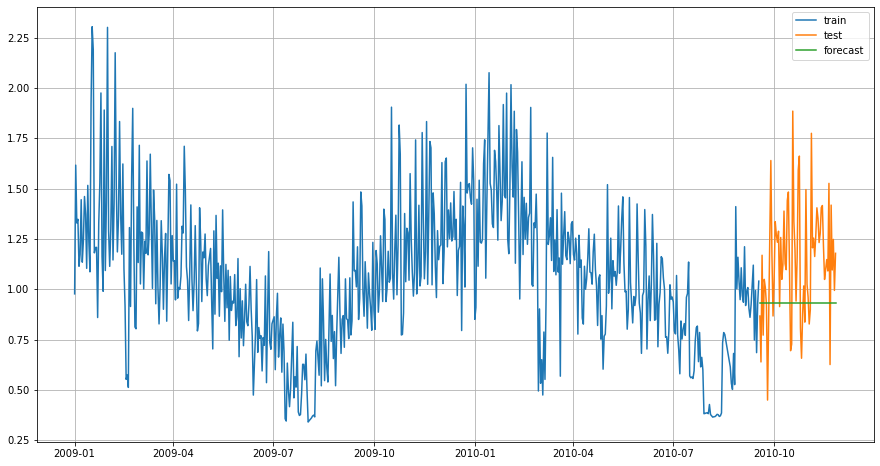

In [32]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [33]:
print("MAE:",MAE(test['active_power_consumed'],SES_predict))
print("MAPE:",MAPE(test['active_power_consumed'],SES_predict))

MAE: 0.28277125172961765
MAPE: 23.92397243523945


##### Double Exponential Smoothing

In [34]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(optimized=True)
DES_model.summary()

Dep. Variable:,active_power_consumed,No. Observations:,625
Model:,Holt,SSE,40.441
Optimized:,True,AIC,-1703.198
Trend:,Additive,BIC,-1685.447
Seasonal:,None,AICC,-1703.062
Seasonal Periods:,None,Date:,"Thu, 07 Apr 2022"
Box-Cox:,False,Time:,23:53:01
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1705174,alpha,True
smoothing_trend,1.9079e-15,beta,True


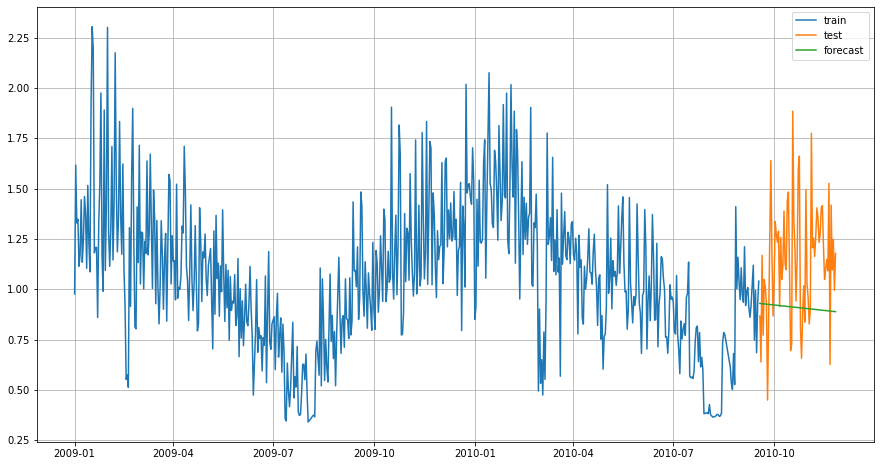

In [36]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [37]:
print("MAE:",MAE(test['active_power_consumed'],DES_predict))
print("MAPE:",MAPE(test['active_power_consumed'],DES_predict))

MAE: 0.2978289119082937
MAPE: 24.927210955257998


##### Triple Exponential Smoothing

In [38]:
TES = ExponentialSmoothing(train,trend='multiplicative',seasonal='additive',initialization_method='estimated')
TES_model = TES.fit(smoothing_level=0.2025981,
    smoothing_trend=4.109e-03,
    smoothing_seasonal=0.000009)
TES_model.summary()

Dep. Variable:,active_power_consumed,No. Observations:,625
Model:,ExponentialSmoothing,SSE,35.944
Optimized:,True,AIC,-1762.864
Trend:,Multiplicative,BIC,-1714.049
Seasonal:,Additive,AICC,-1762.269
Seasonal Periods:,7,Date:,"Thu, 07 Apr 2022"
Box-Cox:,False,Time:,23:53:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2025981,alpha,False
smoothing_trend,0.0041090,beta,False


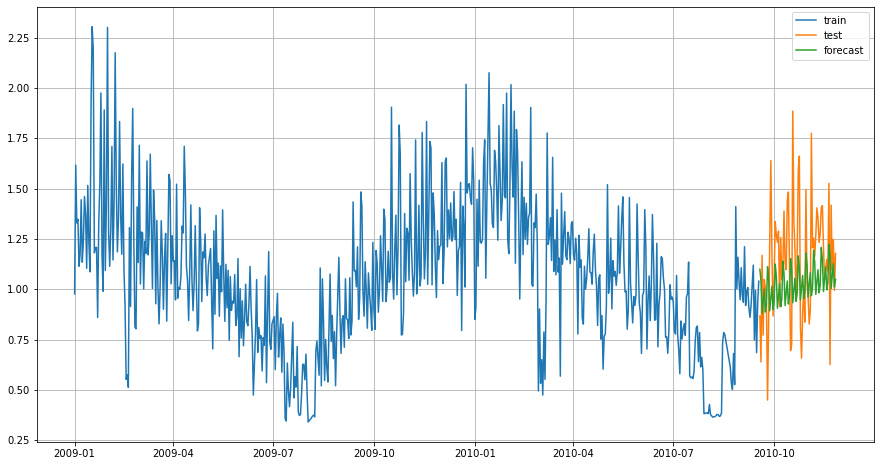

In [39]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [41]:
print("MAE:",MAE(test['active_power_consumed'],TES_predict))
print("MAPE:",MAPE(test['active_power_consumed'],TES_predict))

MAE: 0.24193353360429018
MAPE: 22.398487973078602


##### ACF and PACF plots

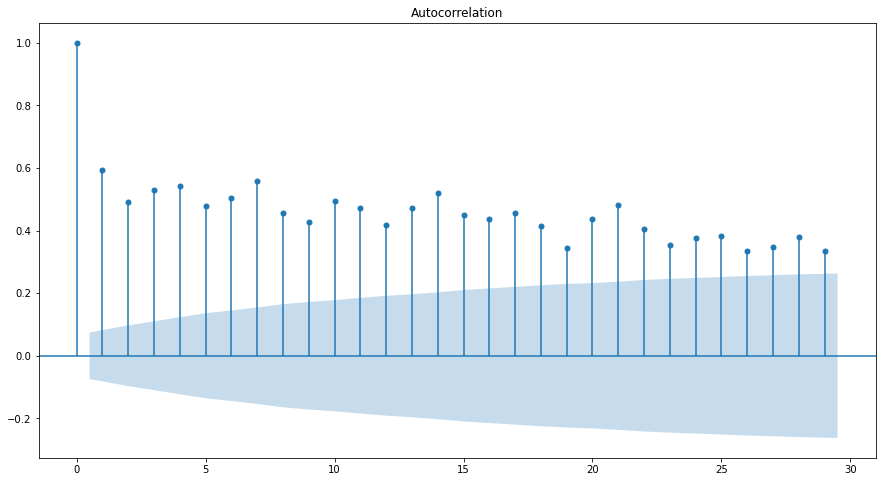

In [42]:
plot_acf(df)
plt.show()

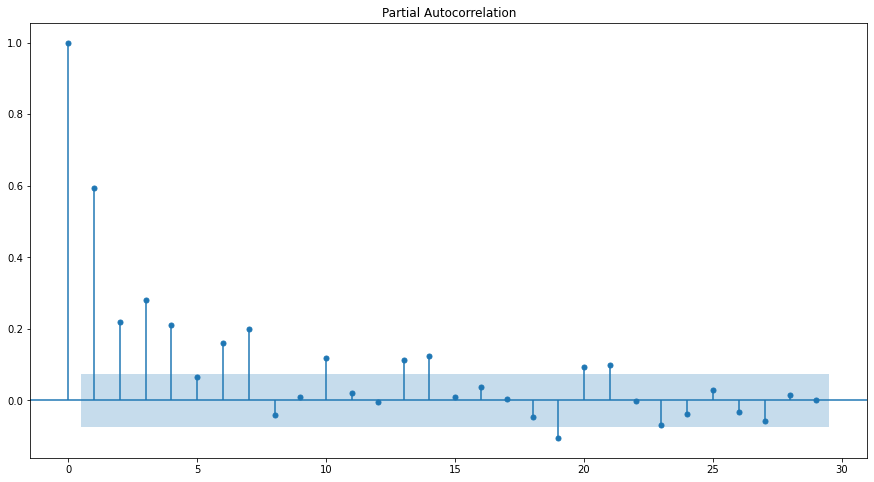

In [43]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [44]:
observations = df.values
df_results = adfuller(observations)
df_results

(-2.1484288289116096,
 0.22549198044652113,
 20,
 674,
 {'1%': -3.4400894360545475,
  '5%': -2.865837730028723,
  '10%': -2.5690586760471605},
 27.11322929346329)

In [45]:
##### Non-stationary series -- proceed with ARIMA & SARIMA model

##### ARIMA Model

In [46]:
import itertools

In [47]:
p = q = range(0,10)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
print("Parameter combinations are:")
for i in range(1,len(pdq)):
    print("ARIMA",pdq[i])

Parameter combinations are:
ARIMA (0, 1, 1)
ARIMA (0, 1, 2)
ARIMA (0, 1, 3)
ARIMA (0, 1, 4)
ARIMA (0, 1, 5)
ARIMA (0, 1, 6)
ARIMA (0, 1, 7)
ARIMA (0, 1, 8)
ARIMA (0, 1, 9)
ARIMA (1, 1, 0)
ARIMA (1, 1, 1)
ARIMA (1, 1, 2)
ARIMA (1, 1, 3)
ARIMA (1, 1, 4)
ARIMA (1, 1, 5)
ARIMA (1, 1, 6)
ARIMA (1, 1, 7)
ARIMA (1, 1, 8)
ARIMA (1, 1, 9)
ARIMA (2, 1, 0)
ARIMA (2, 1, 1)
ARIMA (2, 1, 2)
ARIMA (2, 1, 3)
ARIMA (2, 1, 4)
ARIMA (2, 1, 5)
ARIMA (2, 1, 6)
ARIMA (2, 1, 7)
ARIMA (2, 1, 8)
ARIMA (2, 1, 9)
ARIMA (3, 1, 0)
ARIMA (3, 1, 1)
ARIMA (3, 1, 2)
ARIMA (3, 1, 3)
ARIMA (3, 1, 4)
ARIMA (3, 1, 5)
ARIMA (3, 1, 6)
ARIMA (3, 1, 7)
ARIMA (3, 1, 8)
ARIMA (3, 1, 9)
ARIMA (4, 1, 0)
ARIMA (4, 1, 1)
ARIMA (4, 1, 2)
ARIMA (4, 1, 3)
ARIMA (4, 1, 4)
ARIMA (4, 1, 5)
ARIMA (4, 1, 6)
ARIMA (4, 1, 7)
ARIMA (4, 1, 8)
ARIMA (4, 1, 9)
ARIMA (5, 1, 0)
ARIMA (5, 1, 1)
ARIMA (5, 1, 2)
ARIMA (5, 1, 3)
ARIMA (5, 1, 4)
ARIMA (5, 1, 5)
ARIMA (5, 1, 6)
ARIMA (5, 1, 7)
ARIMA (5, 1, 8)
ARIMA (5, 1, 9)
ARIMA (6, 1, 0)
ARIMA (6, 1,

In [179]:
df_score_arima = pd.DataFrame(columns=['param','aic'])
df_score_arima

,param,aic


In [180]:
from warnings import filterwarnings
filterwarnings('ignore')

In [181]:
for param in pdq:
    try:
        model = ARIMA(train,order=param)
        arima_results = model.fit()
        print("ARIMA",param,"AIC:",arima_results.aic)
        df_score_arima = df_score_arima.append({'param':param,'aic':arima_results.aic},ignore_index=True)
    except:
        continue

ARIMA (0, 1, 0) AIC: 327.4989026236175
ARIMA (0, 1, 1) AIC: 70.53448811568
ARIMA (0, 1, 2) AIC: 61.24740738017135
ARIMA (0, 1, 3) AIC: 60.33210671431743
ARIMA (0, 1, 4) AIC: 61.652419924441574
ARIMA (0, 1, 5) AIC: 60.80385659127296
ARIMA (0, 1, 6) AIC: 59.88580953151495
ARIMA (0, 1, 7) AIC: 56.02062916802788
ARIMA (0, 1, 8) AIC: 45.32938001797629
ARIMA (0, 1, 9) AIC: 47.25177977385306
ARIMA (1, 1, 0) AIC: 231.30530405184982
ARIMA (1, 1, 1) AIC: 63.34764669491551
ARIMA (1, 1, 2) AIC: 60.62239444659485
ARIMA (1, 1, 3) AIC: 62.18543753131644
ARIMA (1, 1, 4) AIC: 64.28753065096953
ARIMA (1, 1, 5) AIC: 62.26806823527545
ARIMA (1, 1, 6) AIC: 61.12431300037383
ARIMA (1, 1, 7) AIC: 53.041267817397284
ARIMA (2, 1, 0) AIC: 135.8191533843201
ARIMA (2, 1, 1) AIC: 61.26901427907114
ARIMA (2, 1, 2) AIC: 61.849950342452985
ARIMA (2, 1, 3) AIC: 36.17870285410163
ARIMA (2, 1, 5) AIC: 14.281275122958505
ARIMA (2, 1, 6) AIC: 16.016899805884805
ARIMA (2, 1, 7) AIC: 18.008724913036303
ARIMA (2, 1, 8) AIC: 

In [208]:
df_score_arima.sort_values('aic')

,param,aic
46,"(5, 1, 5)",7.126450
39,"(4, 1, 6)",7.599574
52,"(6, 1, 5)",9.089856
40,"(4, 1, 7)",9.092275
61,"(7, 1, 6)",12.785212
...,...,...
33,"(4, 1, 0)",105.799469
27,"(3, 1, 0)",105.877258
18,"(2, 1, 0)",135.819153
10,"(1, 1, 0)",231.305304


In [57]:
arima_model = ARIMA(train,(4,1,6))
arima_results = arima_model.fit()
print(arima_results.summary())

                                ARIMA Model Results                                
Dep. Variable:     D.active_power_consumed   No. Observations:                  624
Model:                      ARIMA(4, 1, 6)   Log Likelihood                   8.200
Method:                            css-mle   S.D. of innovations              0.237
Date:                     Fri, 08 Apr 2022   AIC                              7.600
Time:                             00:18:36   BIC                             60.833
Sample:                         01-02-2009   HQIC                            28.286
                              - 09-17-2010                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0006      0.002     -0.393      0.694      -0.004       0.002
ar.L1.D.active_power_consumed    -

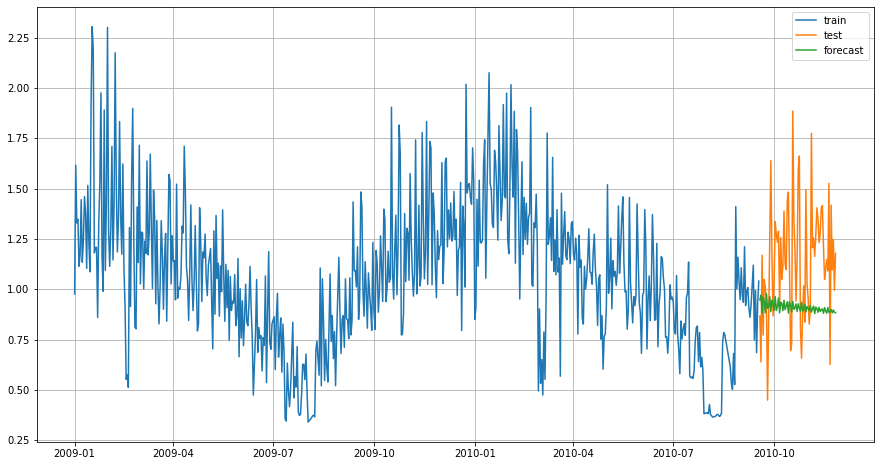

In [58]:
forecasted_values_arima = pd.Series(arima_results.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arima,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [59]:
print("MAE:",MAE(test['active_power_consumed'],forecasted_values_arima))
print("MAPE:",MAPE(test['active_power_consumed'],forecasted_values_arima))

MAE: 0.2997678411943264
MAPE: 25.16592045341251


##### SARIMA Model

In [60]:
import itertools

In [146]:
p = q = range(0,7)
d = range(1,2)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],7) for x in list(itertools.product(p,d,q))]

df_score = pd.DataFrame(columns=['param','seasonal','aic'])
df_score

,param,seasonal,aic


In [147]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        sarimax_results = model.fit()
        print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
        df_score = df_score.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)

SARIMAX (0, 1, 0) (0, 1, 0, 7) AIC: 570.1289233040209
SARIMAX (0, 1, 0) (0, 1, 1, 7) AIC: 265.1422392156644
SARIMAX (0, 1, 0) (0, 1, 2, 7) AIC: 254.40489034955755
SARIMAX (0, 1, 0) (0, 1, 3, 7) AIC: 253.6091189716796
SARIMAX (0, 1, 0) (0, 1, 4, 7) AIC: 233.9537576127228
SARIMAX (0, 1, 0) (0, 1, 5, 7) AIC: 235.3996939381692
SARIMAX (0, 1, 0) (0, 1, 6, 7) AIC: 212.65650193532792
SARIMAX (0, 1, 0) (1, 1, 0, 7) AIC: 428.97894024799007
SARIMAX (0, 1, 0) (1, 1, 1, 7) AIC: 260.3331648768077
SARIMAX (0, 1, 0) (1, 1, 2, 7) AIC: 256.40302844303176
SARIMAX (0, 1, 0) (1, 1, 3, 7) AIC: 245.12554524434023
SARIMAX (0, 1, 0) (1, 1, 4, 7) AIC: 233.24136708332367
SARIMAX (0, 1, 0) (1, 1, 5, 7) AIC: 234.11431392788978
SARIMAX (0, 1, 0) (1, 1, 6, 7) AIC: 210.03337522660846
SARIMAX (0, 1, 0) (2, 1, 0, 7) AIC: 370.35974456042356
SARIMAX (0, 1, 0) (2, 1, 1, 7) AIC: 256.7891734369561
SARIMAX (0, 1, 0) (2, 1, 2, 7) AIC: 264.70796130509416
SARIMAX (0, 1, 0) (2, 1, 3, 7) AIC: 244.60661420688393
SARIMAX (0, 1, 0)

SARIMAX (0, 1, 3) (0, 1, 3, 7) AIC: -3.201947304374002
SARIMAX (0, 1, 3) (0, 1, 4, 7) AIC: 5.266626931383243
SARIMAX (0, 1, 3) (0, 1, 5, 7) AIC: -9.581510448040248
SARIMAX (0, 1, 3) (0, 1, 6, 7) AIC: -57.51129026870768
SARIMAX (0, 1, 3) (1, 1, 0, 7) AIC: 171.4060571608461
SARIMAX (0, 1, 3) (1, 1, 1, 7) AIC: 18.06282826359906
SARIMAX (0, 1, 3) (1, 1, 2, 7) AIC: 11.566923226519457
SARIMAX (0, 1, 3) (1, 1, 3, 7) AIC: -1.6687326899059798
SARIMAX (0, 1, 3) (1, 1, 4, 7) AIC: -0.4449572701122406
SARIMAX (0, 1, 3) (1, 1, 5, 7) AIC: -14.176526617566672
SARIMAX (0, 1, 3) (1, 1, 6, 7) AIC: -56.251592272185746
SARIMAX (0, 1, 3) (2, 1, 0, 7) AIC: 112.5932353278168
SARIMAX (0, 1, 3) (2, 1, 1, 7) AIC: 27.973976314971765
SARIMAX (0, 1, 3) (2, 1, 2, 7) AIC: 14.277576261621945
SARIMAX (0, 1, 3) (2, 1, 3, 7) AIC: 0.22848725724871244
SARIMAX (0, 1, 3) (2, 1, 4, 7) AIC: 1.2490433356580937
SARIMAX (0, 1, 3) (2, 1, 5, 7) AIC: -29.279903984837063
SARIMAX (0, 1, 3) (2, 1, 6, 7) AIC: -54.30457752142068
SARIMAX 

SARIMAX (0, 1, 6) (0, 1, 5, 7) AIC: -14.437503598758454
SARIMAX (0, 1, 6) (0, 1, 6, 7) AIC: -50.56356044459676
SARIMAX (0, 1, 6) (1, 1, 0, 7) AIC: 156.2546409078056
SARIMAX (0, 1, 6) (1, 1, 1, 7) AIC: 13.2636169206678
SARIMAX (0, 1, 6) (1, 1, 2, 7) AIC: 14.90178236904162
SARIMAX (0, 1, 6) (1, 1, 3, 7) AIC: -4.111965051917075
SARIMAX (0, 1, 6) (1, 1, 4, 7) AIC: 0.4946570785188342
SARIMAX (0, 1, 6) (1, 1, 5, 7) AIC: -14.274966300967385
SARIMAX (0, 1, 6) (1, 1, 6, 7) AIC: -50.33713276192789
SARIMAX (0, 1, 6) (2, 1, 0, 7) AIC: 97.53500156928325
SARIMAX (0, 1, 6) (2, 1, 1, 7) AIC: 30.51219505142427
SARIMAX (0, 1, 6) (2, 1, 2, 7) AIC: 14.180881925385094
SARIMAX (0, 1, 6) (2, 1, 3, 7) AIC: -2.617046401451482
SARIMAX (0, 1, 6) (2, 1, 4, 7) AIC: 2.362515034008709
SARIMAX (0, 1, 6) (2, 1, 5, 7) AIC: -12.917482526502113
SARIMAX (0, 1, 6) (2, 1, 6, 7) AIC: -48.886712685384055
SARIMAX (0, 1, 6) (3, 1, 0, 7) AIC: 76.99111441636688
SARIMAX (0, 1, 6) (3, 1, 1, 7) AIC: 13.076205877790848
SARIMAX (0, 1,

SARIMAX (1, 1, 2) (1, 1, 1, 7) AIC: 16.7084219123431
SARIMAX (1, 1, 2) (1, 1, 2, 7) AIC: 11.745268283161138
SARIMAX (1, 1, 2) (1, 1, 3, 7) AIC: -2.4992625974275313
SARIMAX (1, 1, 2) (1, 1, 4, 7) AIC: -5.716042217571406
SARIMAX (1, 1, 2) (1, 1, 5, 7) AIC: -4.2709684606117975
SARIMAX (1, 1, 2) (1, 1, 6, 7) AIC: -36.39636497436326
SARIMAX (1, 1, 2) (2, 1, 0, 7) AIC: 96.58709760587277
SARIMAX (1, 1, 2) (2, 1, 1, 7) AIC: 26.08634608968012
SARIMAX (1, 1, 2) (2, 1, 2, 7) AIC: 18.679090263276294
SARIMAX (1, 1, 2) (2, 1, 3, 7) AIC: 0.17164870387945896
SARIMAX (1, 1, 2) (2, 1, 4, 7) AIC: -4.219859068635202
SARIMAX (1, 1, 2) (2, 1, 5, 7) AIC: 0.7604445519957395
SARIMAX (1, 1, 2) (2, 1, 6, 7) AIC: -31.009966456453057
SARIMAX (1, 1, 2) (3, 1, 0, 7) AIC: 76.82974129228373
SARIMAX (1, 1, 2) (3, 1, 1, 7) AIC: 14.470352326582642
SARIMAX (1, 1, 2) (3, 1, 2, 7) AIC: 16.3167896316983
SARIMAX (1, 1, 2) (3, 1, 3, 7) AIC: -0.31973964527680465
SARIMAX (1, 1, 2) (3, 1, 4, 7) AIC: -8.180695853383241
SARIMAX (1,

SARIMAX (1, 1, 5) (1, 1, 4, 7) AIC: 0.24976918037000928
SARIMAX (1, 1, 5) (1, 1, 5, 7) AIC: -15.686127827760174
SARIMAX (1, 1, 5) (1, 1, 6, 7) AIC: -51.00040157895518
SARIMAX (1, 1, 5) (2, 1, 0, 7) AIC: 96.89564411161564
SARIMAX (1, 1, 5) (2, 1, 1, 7) AIC: 29.44106577065285
SARIMAX (1, 1, 5) (2, 1, 2, 7) AIC: 13.874352659696243
SARIMAX (1, 1, 5) (2, 1, 3, 7) AIC: -4.969294437316346
SARIMAX (1, 1, 5) (2, 1, 4, 7) AIC: 2.0727081613479044
SARIMAX (1, 1, 5) (2, 1, 5, 7) AIC: -12.13506643330716
SARIMAX (1, 1, 5) (2, 1, 6, 7) AIC: -49.643310805215066
SARIMAX (1, 1, 5) (3, 1, 0, 7) AIC: 76.26663001973286
SARIMAX (1, 1, 5) (3, 1, 1, 7) AIC: 12.302785037348983
SARIMAX (1, 1, 5) (3, 1, 2, 7) AIC: 14.761047837618527
SARIMAX (1, 1, 5) (3, 1, 3, 7) AIC: 0.5720779104709592
SARIMAX (1, 1, 5) (3, 1, 4, 7) AIC: 3.213574023156177
SARIMAX (1, 1, 5) (3, 1, 5, 7) AIC: -24.988720423448335
SARIMAX (1, 1, 5) (3, 1, 6, 7) AIC: -49.15382730852669
SARIMAX (1, 1, 5) (4, 1, 0, 7) AIC: 54.61981187930674
SARIMAX (1,

KeyboardInterrupt: 

In [148]:
df_score.sort_values('aic')

,param,seasonal,aic
153,"(0, 1, 3)","(0, 1, 6, 7)",-57.511290
181,"(0, 1, 3)","(4, 1, 6, 7)",-57.477350
188,"(0, 1, 3)","(5, 1, 6, 7)",-56.902669
160,"(0, 1, 3)","(1, 1, 6, 7)",-56.251592
202,"(0, 1, 4)","(0, 1, 6, 7)",-55.640657
...,...,...,...
49,"(0, 1, 1)","(0, 1, 0, 7)",356.936766
14,"(0, 1, 0)","(2, 1, 0, 7)",370.359745
7,"(0, 1, 0)","(1, 1, 0, 7)",428.978940
343,"(1, 1, 0)","(0, 1, 0, 7)",461.040408


In [154]:
model = SARIMAX(train,
                       order = (4,1,6),
                       seasonal_order = (6,1,4,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [155]:
print(sarimax_results.summary())

                                          SARIMAX Results                                           
Dep. Variable:                        active_power_consumed   No. Observations:                  625
Model:             SARIMAX(4, 1, 6)x(6, 1, [1, 2, 3, 4], 7)   Log Likelihood                  42.094
Date:                                      Fri, 08 Apr 2022   AIC                            -42.188
Time:                                              02:30:43   BIC                             49.107
Sample:                                          01-01-2009   HQIC                            -6.570
                                               - 09-17-2010                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3103      2.116  

In [156]:
forecast = sarimax_results.forecast(len(test))

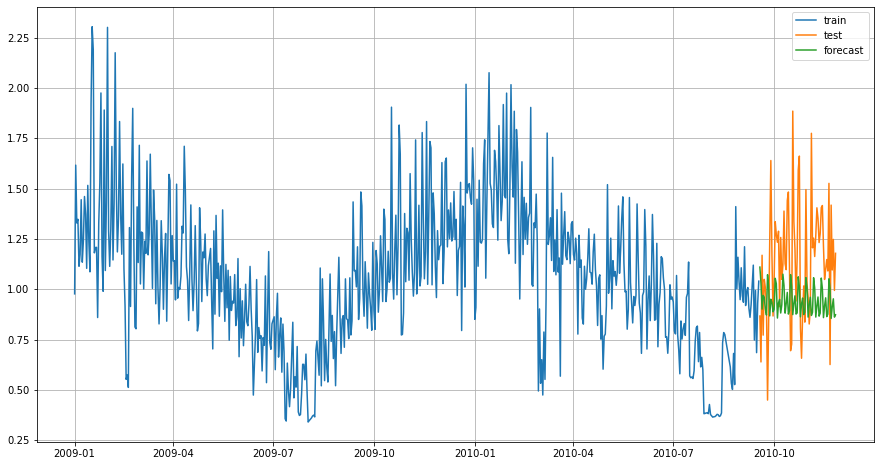

In [157]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [158]:
print("MAE:",MAE(test['active_power_consumed'],forecast))
print("MAPE:",MAPE(test['active_power_consumed'],forecast))

MAE: 0.29264541066438265
MAPE: 25.669231706702693


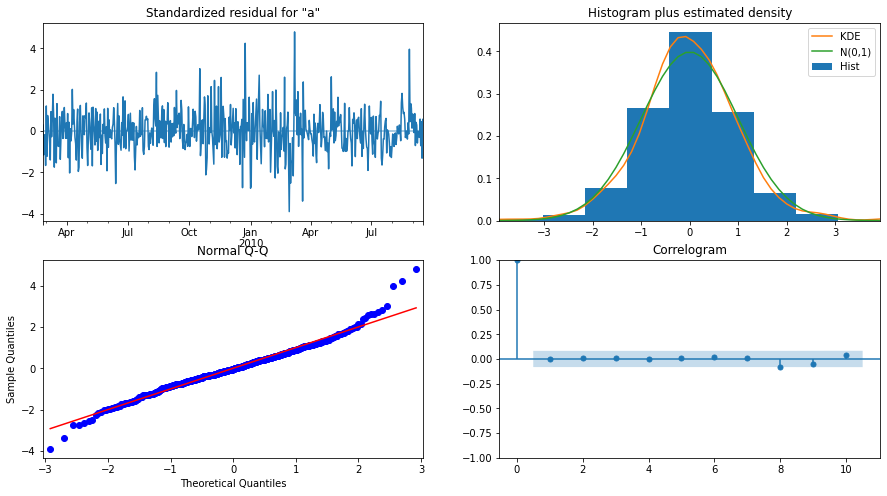

In [159]:
sarimax_results.plot_diagnostics();